# COVID-19's Impact on Healthcare Accessibility
### By: Tristan Call and Maria Elena Aviles-Baquero

## Introductory

In [1]:


# STEPS
# 1. Focus on Washington (for now aka. generalize code (as always))
# 2. create default values

# load data function: through MyPyTable()

# data analysis functions:
# group_by()
# get_column() - MyPyTable
# plotting - whatever we used in class
    # save_graph() function
# output result files (? TBD)

# summary_stats from MyPyTable

## Data Analysis

TODO:
- load in data to use
- create analysis functions (something that takes in specific attributes and returns them)

In [2]:
# some useful mysklearn package import statements and reloads
import importlib

import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

# uncomment once you paste your mypytable.py into mysklearn package
import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 

import mysklearn.plot_utils
importlib.reload(mysklearn.plot_utils)
import mysklearn.plot_utils as plot_utils

import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyKNeighborsClassifier, MySimpleLinearRegressor, MyNaiveBayesClassifier

import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
import mysklearn.myevaluation as myevaluation

import os
import pandas as pd

## Manipulate Data into Useable Format
The first thing we need to do is grab the data from the sas file and manipulate it into a format and size which is workable with our very much not optimized dataset. Part of this involves dropping rows with NaNs or -99s (seen but unanswered questions) in them ahead of time. Overall we aim to go from about 70,000 results to a more reasonable < 10,000.

In [3]:
# Grab the data
week21_filename = os.path.join("input_data", "pulse2020_puf_21.sas7bdat")
iterator = pd.read_sas(week21_filename, chunksize=5000)
alldata = []
for chunk in iterator:
    alldata.append(chunk)

relevant_attributes = ["TBIRTH_YEAR", "EGENDER", "RHISPANIC", "RRACE", "EEDUC", "INCOME", "DELAY", "NOTGET"]

# Grab a chunk of data with the attributes we are interested in, minus Nans, and save to a local file
data = alldata[0][["TBIRTH_YEAR", "EGENDER", "RHISPANIC", "RRACE", "EEDUC", "INCOME", "DELAY", "NOTGET"]]
working_data_filename = os.path.join("input_data", "week21_working.csv")
nafree_data = data.dropna()

# Get rid of -99 results (aka seen but not answered)
nafree_data = nafree_data[nafree_data.INCOME != -99]
nafree_data = nafree_data[nafree_data.DELAY != -99]
nafree_data = nafree_data[nafree_data.NOTGET != -99]
print(nafree_data)

# Save to file
nafree_data.to_csv(working_data_filename)

      TBIRTH_YEAR  EGENDER  RHISPANIC  RRACE  EEDUC  INCOME  DELAY  NOTGET
1          1969.0      2.0        1.0    1.0    7.0     6.0    1.0     2.0
2          1959.0      2.0        1.0    1.0    7.0     4.0    1.0     1.0
4          1967.0      1.0        1.0    1.0    4.0     6.0    2.0     2.0
5          1965.0      1.0        1.0    1.0    7.0     6.0    2.0     2.0
6          1962.0      2.0        1.0    2.0    4.0     1.0    2.0     2.0
...           ...      ...        ...    ...    ...     ...    ...     ...
4993       1964.0      2.0        1.0    1.0    4.0     1.0    2.0     2.0
4994       1984.0      1.0        1.0    1.0    4.0     7.0    1.0     1.0
4995       1973.0      1.0        1.0    1.0    6.0     8.0    2.0     2.0
4997       1976.0      2.0        1.0    1.0    3.0     3.0    1.0     1.0
4999       1958.0      2.0        1.0    1.0    7.0     5.0    2.0     2.0

[3909 rows x 8 columns]


## Organize the data
Next we want to get the data into a more useful format. Step one of this is chunk years into decades to have a reasonable number of attribute values for year according to the below:

years | label
-|-
1932-1941 | 1
1942-1951 | 2
1952-1961 | 3
1962-1971 | 4
1972-1981 | 5
1982-1991 | 6
1992-2002 | 7

Next we want to create a DELAYNOTGET column as a composite of delay and notget.

In [4]:
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

# Load the data into a mypytable for future analysis
overall_table = MyPyTable()
overall_table.load_from_file(working_data_filename)
overall_table.convert_to_numeric()

# Convert year into bigger categorical chunks
year_col = overall_table.get_column("TBIRTH_YEAR")
year_label = [x + 1 for x in range(7)]
cutoffs = [1932 + 10 * x for x in range(8)]
year_col = myutils.categorize_continuous_list(year_col, cutoffs, year_label)

# Create DELAYNOTGET column
delay = overall_table.get_column("DELAY")
notget = overall_table.get_column("NOTGET")
delaynotget = []
for i in range(len(delay)):
    if delay[i] == 1 or notget[i] == 1:
        delaynotget.append(1)
    else:
        delaynotget.append(2)
        
# Combine all the above into the overall_table
overall_table.column_names.append("DELAYNOTGET")
overall_table.data = [[overall_table.data[i][0]] + [year_col[i]] + overall_table.data[i][2:] + [delaynotget[i]] for i in range(len(year_col))]
# overall_table.pretty_print()

# Classification
In this section we will classify our results using our classifiers

## Visualizations

In [5]:
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 
importlib.reload(mysklearn.plot_utils)
import mysklearn.plot_utils as plot_utils


# use overall_table object declared above to compute the stats for all attributes
table_stats = overall_table.compute_summary_statistics(relevant_attributes)
# print out the statistics table
table_stats.pretty_print()

# add a graph?

attribute      min    max    mid      avg    median       std
-----------  -----  -----  -----  -------  --------  --------
TBIRTH_YEAR      1      7    4    4.0967          4  1.55314
EGENDER          1      2    1.5  1.59964         2  0.489971
RHISPANIC        1      2    1.5  1.08314         1  0.276096
RRACE            1      4    2.5  1.31491         1  0.778868
EEDUC            1      7    4    5.33078         6  1.42407
INCOME           1      8    4.5  4.5559          5  2.07749
DELAY            1      2    1.5  1.65004         2  0.476958
NOTGET           1      2    1.5  1.74648         2  0.435025


(Add notes here regarding findings in statistics summary)

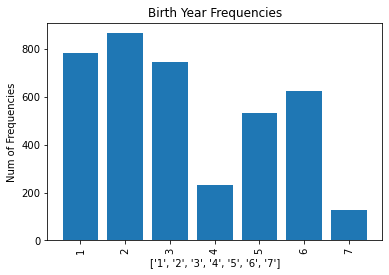

In [6]:
importlib.reload(mysklearn.plot_utils)
import mysklearn.plot_utils as plot_utils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

birth_years = ["1", "2", "3", "4", "5", "6", "7"]
items, birth_frequencies = myutils.get_item_frequency(overall_table.get_column("TBIRTH_YEAR"))

plot_utils.plot_bar(birth_years, birth_frequencies, birth_years, "Num of Frequencies", "Birth Year Frequencies")

In [ ]:
# FINISH THIS
group_names, subtables = overall_table.group_by("DELAYNOTGET")

